In [1]:
import umap.aligned_umap
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-28 22:32:29.627888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 22:32:30.221806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-28 22:32:30.221855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

In [2]:
path1 = "/home/yifan/dataset/clean/pairflip/cifar10/0"
path2 = "/home/yifan/Exp/Dropout/0.3/experiment1"

In [3]:
def getData(path,epoch):
    ##### get representation
    X_train = np.load(os.path.join(path,"Model","Epoch_{}".format(epoch),"train_data.npy"))
    X_test = np.load(os.path.join(path,"Model","Epoch_{}".format(epoch),"test_data.npy"))
    
    #### get label
    training_label_loc =  os.path.join(path, "Training_data", "training_dataset_label.pth")
    y_train = torch.load(training_label_loc, map_location="cpu")
    y_train = y_train.numpy()
    testing_label_loc =  os.path.join(path, "Testing_data", "testing_dataset_label.pth") 
    y_test = torch.load(testing_label_loc, map_location="cpu")
    y_test = y_test.numpy()

    return X_train, X_test, y_train, y_test


In [4]:
X_train1, X_test1, y_train1, y_test1 = getData(path1,150)
X_train2, X_test2, y_train2, y_test2 = getData(path2,150)

In [5]:
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1])

In [6]:
import numpy as np
from scipy.linalg import svd

# 假设 data1 和 data2 已经给出
# 例如：
# data1 = np.random.rand(50000, 512)
# data2 = np.random.rand(50000, 512)

def orthogonal_mapping(data1, data2):
    """
    使用Orthogonal Mapping方法将data2映射到data1空间。
    
    :param data1: numpy array, shape (n_samples, n_features)
    :param data2: numpy array, shape (n_samples, n_features)
    :return: data2_mapped: numpy array, 映射后的data2
    """
    # 步骤1: 中心化数据
    data1_centered = data1 - np.mean(data1, axis=0)
    data2_centered = data2 - np.mean(data2, axis=0)

    # 步骤2: 计算交叉协方差矩阵
    C = data2_centered.T @ data1_centered

    # 步骤3: 奇异值分解
    U, _, Vt = svd(C)

    # 步骤4: 计算正交映射矩阵
    W = U @ Vt

    # 步骤5: 应用映射矩阵
    data2_mapped = data2_centered @ W
    
    return data2_mapped

# 使用函数
# data2_mapped = orthogonal_mapping(data1, data2)


In [7]:
print(X_train1.shape)
print(X_train2.shape)
data2_mapped = orthogonal_mapping(X_train1,X_train2)

(50000, 512)
(50000, 512)


In [8]:
np.random.seed(23423)
import sys
sys.path.append('/home/yifan/projects/cophi/ContraVis')
from eval.evaluate import *

nA = 3000
nRest = 6000
#set_up_parameters

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
neg_sample_rate = 5
n = X_train1.shape[0]
    


%load_ext autoreload
%autoreload 2

np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train1
y_train_rp = y_train1
print(X_train_rp.shape)

X_train200, _, y_train200, _ = getData(path1,200)
X_train150, _, y_train150, _ = getData(path1,150)
X_train100, _, y_train100, _ = getData(path1,100)
X_train50, _, y_train50, _ = getData(path1,50)
X_train1, _, y_train1, _ = getData(path1,1)
X_train50 = X_train50.reshape(X_train50.shape[0],X_train50.shape[1] )
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] )


X2_train200, _, y2_train200, _ = getData(path2,200)
X2_train200 = X2_train200.reshape(X2_train200.shape[0],X2_train200.shape[1] )

X2_train200_before = X2_train200

X2_train200 = orthogonal_mapping(X_train1, X2_train200)



print("nn preserving rate",evaluate_high_dimesion_trans_knn_preserving(X2_train200_before, X2_train200))


X_train_rp = X_train200[:(nA +nRest )] 
y_train_rp = y_train200[:(nA +nRest )] 



X_train_rp = np.concatenate((X_train_rp, X2_train200[:nRest]),axis=0)
y_train_rp = np.concatenate((y_train_rp, y2_train200[:nRest]),axis=0)

# X_train_rp = np.concatenate((X_train_rp, X_train100[:nRest]),axis=0)
# y_train_rp = np.concatenate((y_train_rp, y_train100[:nRest]),axis=0)

# X_train_rp = np.concatenate((X_train_rp, X_train50[:nRest]),axis=0)
# y_train_rp = np.concatenate((y_train_rp, y_train50[:nRest]),axis=0)

# X_train_rp = np.concatenate((X_train_rp, X_train1[:nRest]),axis=0)
# y_train_rp = np.concatenate((y_train_rp, y_train1[:nRest]),axis=0)



SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(2):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

(50000, 512)
nn preserving rate 1.0
in loop
in loop
out of loop
(3000, 512) (2, 6000, 512) (6000, 512) (2, 9000, 512) 2


In [42]:
from MANE import *

GRAPHS = []
ROWS = []
COLUMNS = []
WEIGHTS = []
EPOCHS_PER_SAMPLE = []
EPOCH_OF_NEXT_SAMPLE = []
EPOCHS_PER_NEGATIVE_SAMPLE = []
EPOCH_OF_NEXT_NEGATIVE_SAMPLE = []

SET_IDX = []
K_IDX = []

for iset in range(n_SET):
    graph = get_prob_matrix(DATA[iset],n_neighbors=n_neighbors)
    graph.data[graph.data < (graph.data.max() / float(epochs))] = 0.0
    graph.eliminate_zeros()
    
    epochs_per_sample = make_epochs_per_sample(graph.data, epochs)
    epoch_of_next_sample = epochs_per_sample.copy()
    epochs_per_negative_sample = epochs_per_sample / neg_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()
    
    set_idx = iset*np.ones(len(epochs_per_sample),dtype=np.int)
    k_idx = np.arange(epochs_per_sample.shape[0],dtype=np.int)
    
    SET_IDX.append(set_idx)
    K_IDX.append(k_idx)
    
    ROWS.append(graph.row)
    COLUMNS.append(graph.col)
    EPOCHS_PER_SAMPLE.append(epochs_per_sample)
    EPOCH_OF_NEXT_SAMPLE.append(epoch_of_next_sample)
    EPOCHS_PER_NEGATIVE_SAMPLE.append(epochs_per_negative_sample)
    EPOCH_OF_NEXT_NEGATIVE_SAMPLE.append(epoch_of_next_negative_sample)
    
    print(epochs_per_sample.shape)
print(SET_IDX)



SET_IDX = np.array(np.concatenate(SET_IDX)).reshape(-1)
K_IDX = np.array(np.concatenate(K_IDX)).reshape(-1)

n_idx = np.random.permutation(len(SET_IDX))
SET_IDX = SET_IDX[n_idx]
K_IDX = K_IDX[n_idx]

print('done')

Processed  1000  of  9000  samples.
Processed  2000  of  9000  samples.
Processed  3000  of  9000  samples.
Processed  4000  of  9000  samples.
Processed  5000  of  9000  samples.
Processed  6000  of  9000  samples.
Processed  7000  of  9000  samples.
Processed  8000  of  9000  samples.
Processed  9000  of  9000  samples.


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

(406354,)
Processed  1000  of  9000  samples.
Processed  2000  of  9000  samples.
Processed  3000  of  9000  samples.
Processed  4000  of  9000  samples.
Processed  5000  of  9000  samples.
Processed  6000  of  9000  samples.
Processed  7000  of  9000  samples.
Processed  8000  of  9000  samples.
Processed  9000  of  9000  samples.
(391826,)
[array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1])]
done


Hyperparameters a = 1.5769434604035877 and b = 0.8950608780665811


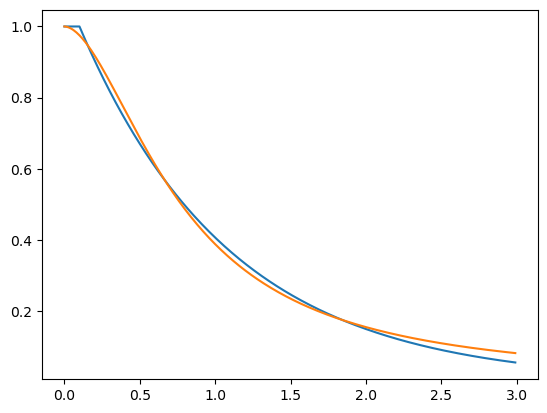

In [43]:
from scipy import optimize
x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')
plt.show()

In [44]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
expansion = 10.0 / np.abs(embA).max()
embA = (embA * expansion).astype(np.float32)

emb_sets = []

print('before initi')

for i in range(n_SET):
    data = DATA[i]
    emb_i = pca.transform(data[nA:])
    emb_i = (emb_i * expansion).astype(np.float32)
    
    emb_sets.append(emb_i)
    
print('after init')

repulsion_strength=1.0

init_lr = 1.0

#SET_IDX
#K_IDX

print(len(EPOCH_OF_NEXT_NEGATIVE_SAMPLE))
print(EPOCH_OF_NEXT_NEGATIVE_SAMPLE[0].shape)

import timeit

for epoch in range(epochs):
    pass
    
    if epoch%20==0:
        print('epoch ', epoch, 'of ', epochs)
    #print('epoch ', epoch, 'of ', epochs)
    start = timeit.default_timer()
    
    lr = init_lr * (1.0 - float(epoch)/float(epochs))
    
    #'''
    one_epoch_nsets(emCommon=embA, embS=emb_sets,
                     rows=ROWS, columns=COLUMNS,
                     nCommon=nA, n_points_=N_DATA,
                     Set=SET_IDX, K_idx=K_IDX,
                     a=a, b=b, dim=n_components,
                     lr=lr, epoch=epoch,
                     epochs_per_sample=EPOCHS_PER_SAMPLE,
                     epoch_of_next_sample=EPOCH_OF_NEXT_SAMPLE,
                     epochs_per_negative_sample=EPOCHS_PER_NEGATIVE_SAMPLE,
                     epoch_of_next_negative_sample=EPOCH_OF_NEXT_NEGATIVE_SAMPLE,
                     repulsion_strength=repulsion_strength)
    #'''
    stop = timeit.default_timer()
    print('Time for epoch ', epoch, ': ', stop - start) 

before initi
after init
2
(406354,)
epoch  0 of  200
Time for epoch  0 :  0.08301475644111633
Time for epoch  1 :  0.08212246373295784
Time for epoch  2 :  0.08654946461319923
Time for epoch  3 :  0.07990127243101597
Time for epoch  4 :  0.08329047821462154
Time for epoch  5 :  0.08450315333902836
Time for epoch  6 :  0.08724280260503292
Time for epoch  7 :  0.0870512705296278
Time for epoch  8 :  0.08955088630318642
Time for epoch  9 :  0.09059246070683002
Time for epoch  10 :  0.09198951348662376
Time for epoch  11 :  0.091642951592803
Time for epoch  12 :  0.09407500736415386
Time for epoch  13 :  0.09323562495410442
Time for epoch  14 :  0.09597255848348141
Time for epoch  15 :  0.09899132326245308
Time for epoch  16 :  0.09580980241298676
Time for epoch  17 :  0.09784875623881817
Time for epoch  18 :  0.09451424703001976
Time for epoch  19 :  0.09399078041315079
epoch  20 of  200
Time for epoch  20 :  0.09385739825665951
Time for epoch  21 :  0.09587820991873741
Time for epoch  22

(3000, 2)


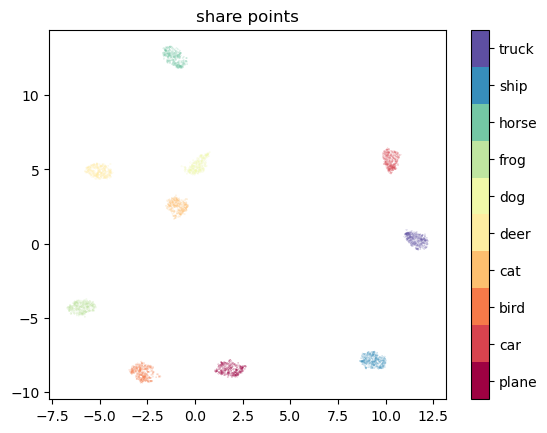

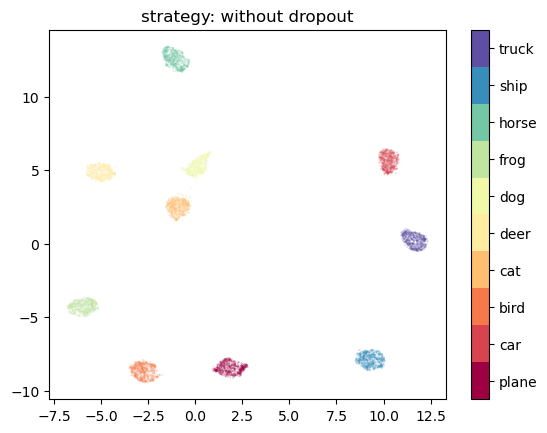

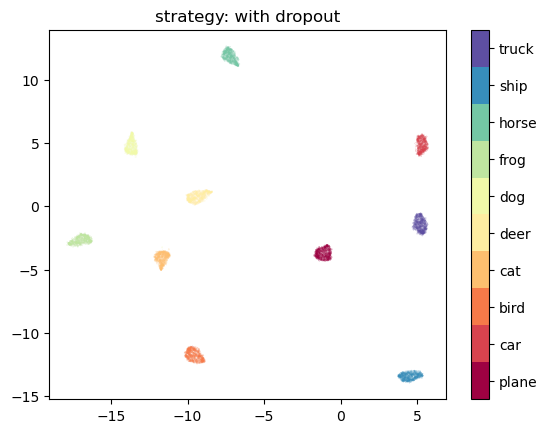

In [45]:
%matplotlib inline


classes= ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

plt.figure()
plt.title('share points')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

epochclist = ['without dropout','with dropout']

for i in range(n_SET):

    plt.figure()
    plt.title('strategy: {}'.format(epochclist[i]))
    embB = emb_sets[i]
    y_embB = y_SETS[i]
    plt.scatter(embB[:,0], embB[:,1], c=y_embB, s=0.01, cmap='Spectral')
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)
